# Binary and Grayscale Morphology
Mount the shared google drive folder to read the images

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import cv2
from matplotlib import pyplot as plt

from time import time

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Recap some operators for image smoothing and thresholding

Image size  (256, 256)  Depth:  uint8


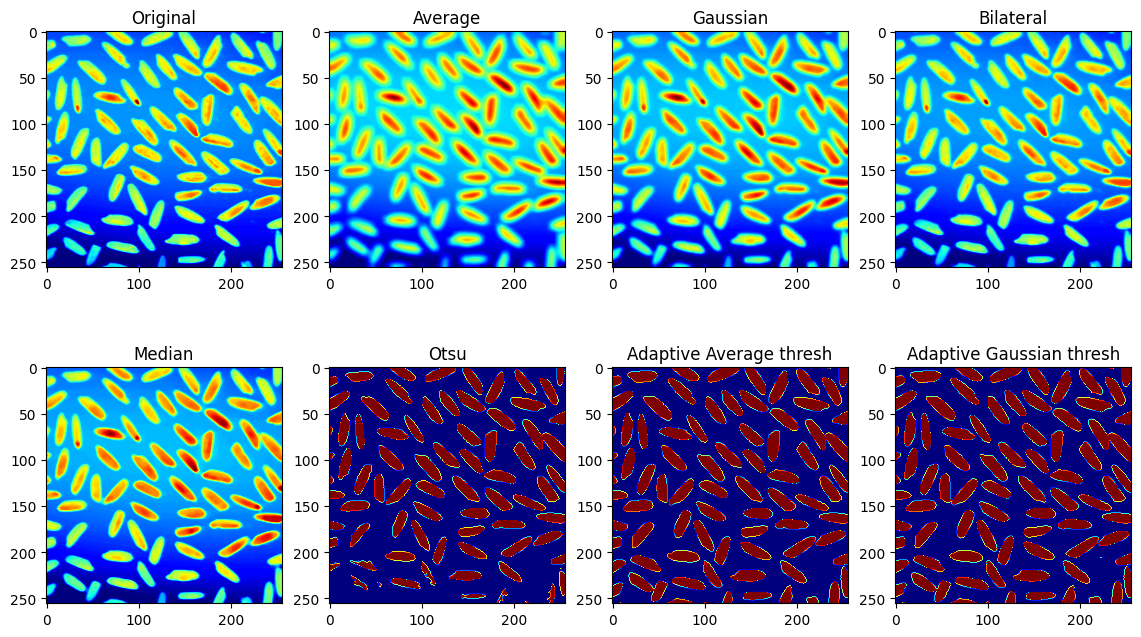

In [ ]:
# riassunto di come funzionano smoothing e sogliatura,

image_path = '/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Sample_images/'

img = cv2.imread(image_path + 'rice.tif', 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)
width=9

imgSmooAvera = cv2.blur(img, (width,width))
imgSmooGauss = cv2.GaussianBlur(img, (width,width), 0)
imgSmooBila = np.uint16(cv2.bilateralFilter(np.float32(img),width,50,0))
imgSmooMed = cv2.medianBlur(img, 5)

trsh, img_bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # otsu
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,57,2) # adattiva, raggio a 57, media # raggio e soglia
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,87,6) # adattiva, media gaussiana, soglia determinata da una statistica che estrae la media all'interno di una regione circolare centrata su un pixel di interesse

# se valore pixel corrente è sup. media corrente + soglia 2 (o 6), se eccede diventa bianco sennò è a 0

plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(img, cmap='jet')
plt.title('Original')
plt.subplot(2,4,2)
plt.imshow(imgSmooAvera, cmap='jet')
plt.title('Average')
plt.subplot(2,4,3)
plt.imshow(imgSmooGauss, cmap='jet')
plt.title('Gaussian')
plt.subplot(2,4,4)
plt.imshow(imgSmooBila, cmap='jet')
plt.title('Bilateral')
plt.subplot(2,4,5)
plt.imshow(imgSmooMed, cmap='jet')
plt.title('Median')
plt.subplot(2,4,6)
plt.imshow(img_bw, cmap='jet')
plt.title('Otsu')
plt.subplot(2,4,7)
plt.imshow(th2, cmap='jet')
plt.title('Adaptive Average thresh')
plt.subplot(2,4,8)
plt.imshow(th3, cmap='jet')
plt.title('Adaptive Gaussian thresh')
plt.show()


## Comments
In figura è riportata un'immagine in falsi colori, rappresentante dei chicchi di riso a cui sono state applicate operazioni di sogliatura e smoothing.
La scelta di un kernel ad ampiezza più grande porterà un maggiore effetto di smoothing rispetto a uno più piccolo, che può essere modellato andando a lavorare nell'ampiezza del kernel. Nella sogliatura, invece, di particolare importanza è la scelta del valore di soglia, in particolare nelle tecniche adattive se il valore di pixel corrente è superiore alla media scelta e alla soglia, diventa bianco, quindi 1, altrimenti sarà posto a 0


## Erode, Dilate, Open, Close

Image size  (256, 256)  Depth:  uint8


Text(0.5, 1.0, 'Closed')

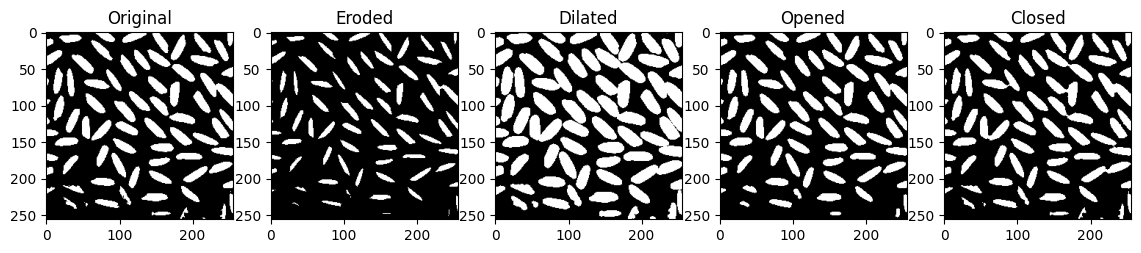

In [ ]:
#

img = cv2.imread(image_path + 'rice.tif', 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)

# Apply Otsu
trsh, img_bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Define the structuring element
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)) # estensione es cerchio raggio 5

img_eroded = cv2.erode(img_bw, se, iterations = 1) # erosione
img_dilated = cv2.dilate(img_bw, se, iterations = 1) # dilatazione
img_opened = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, se) # apertura, parametrizzazione di una stessa funzione
img_closed = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se) # chiusura, parametrizzazione di una stessa funzione

plt.figure(figsize=(14,8))
plt.subplot(1,5,1)
plt.imshow(img_bw, cmap='gray')
plt.title('Original')
plt.subplot(1,5,2)
plt.imshow(img_eroded , cmap='gray')
plt.title('Eroded')
plt.subplot(1,5,3)
plt.imshow(img_dilated, cmap='gray')
plt.title('Dilated')
plt.subplot(1,5,4)
plt.imshow(img_opened, cmap='gray')
plt.title('Opened')
plt.subplot(1,5,5)
plt.imshow(img_closed, cmap='gray')
plt.title('Closed')

# apertura cosa succede quando aumenta estensione es, morfologia matematica forte non linearità rispetto all'es

## Comments
Modificando le dimensioni del raggio dell'elemento strutturante dandogli un valore molto grande pari a 15 (per esempio), possiamo notare come nell'erosione si abbia una totale perdita dell'informazione, portando l'immagine ad assumere tutti i valori pari a 0. Nell'apertura invece verrà preservato un piccolo spot bianco, che, in caso di un aumento di raggio (ad esempio 20), scomparirà, lasciando come risultato un'immagine completamente nera.
Scegliendo un raggio più piccolo di quello di partenza (ovvero 5) e ponendone uno pari a 3, è possibile notare una erosione e una apertura meno accentuate, lasciando quasi invariate le immagini originali. Scegliendo invece una buona soglia, ovvero quella di partenza pari a 5, è invece possibile osservare gli effetti delle operazioni.

## Morphological Reconstruction by dilation

Image size  (256, 256)  Depth:  uint8


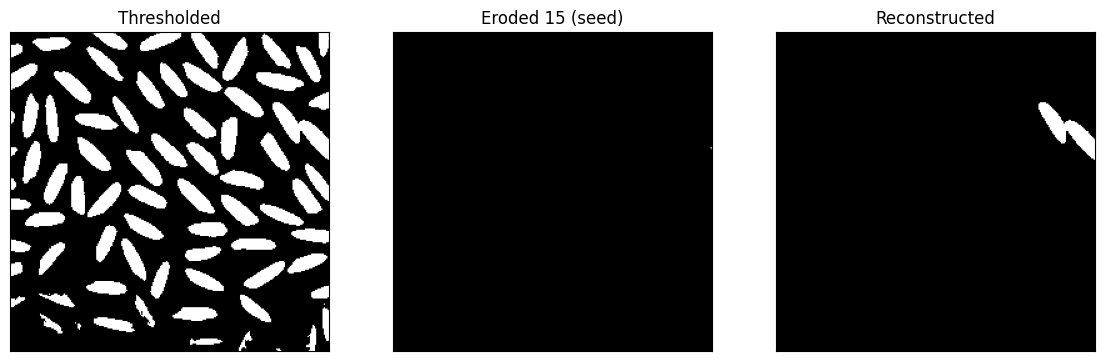

In [ ]:
def morpho_reconstruct(img_mask, img_seed):
    se = np.ones((3,3)).astype('uint8')
    loop = True
    img_tmp1 = img_seed
    while loop:
        img_tmp2 = cv2.dilate(img_tmp1, se, iterations = 1)
        img_tmp2 = np.minimum(img_tmp2, img_mask ) # minimum is used so as to operate both on binary and grayscale images
        if np.array_equal(img_tmp1, img_tmp2):
            loop = False
            return img_tmp1
        else:
            img_tmp1 = img_tmp2

img = cv2.imread(image_path + 'rice.tif', 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)
# Apply Otsu
trsh, img_bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

radius = 15
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_seed = cv2.erode(img_bw, se, iterations = 1)
img_reco = morpho_reconstruct(img_bw, img_seed)

plt.figure(figsize=(14,8))
plt.subplot(1,3,1), plt.imshow(img_bw,cmap = 'gray')
plt.title('Thresholded'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2), plt.imshow(img_seed,cmap = 'gray')
plt.title('Eroded %d (seed)'%(radius)), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3), plt.imshow(img_reco,cmap = 'gray')
plt.title('Reconstructed'), plt.xticks([]), plt.yticks([])
plt.show()


## Comments
Con open by recunstruction l'immagine dei seed o dei marker è ottenuta dall'erosione dell'immagine di partenza. Non ho un marker per ogni chicco di riso, lo costruisco andando a erodere i chicchi di riso stessi attraverso la rimozione di regioni piccole che non sono dei chicchi, mantendo un seme per ognuna delle regioni corrispondenti al riso. Se scegliamo un raggio pari a 9 (valore preimpostato) possiamo vedere nell'immagine ricostruita non compariranno quelle frazioni di chicchi che abbiamo in basso a destra nell'immagine originale. Modificando il raggio in un valore più piccolo, 3, è possibile notare come stavolta le porzioni di riso in basso a destra compariranno nella ricostruzione, in quanto ne sono stati costruiti i marker. Se andiamo a scegliere un raggio più grande, 15, possiamo renderci conto che questa non è una buona scelta di rappresentazione, in quanto verranno riportati solamente due chicchi in alto a destra.

## Hole filling

Image size  (265, 272)  Depth:  uint8


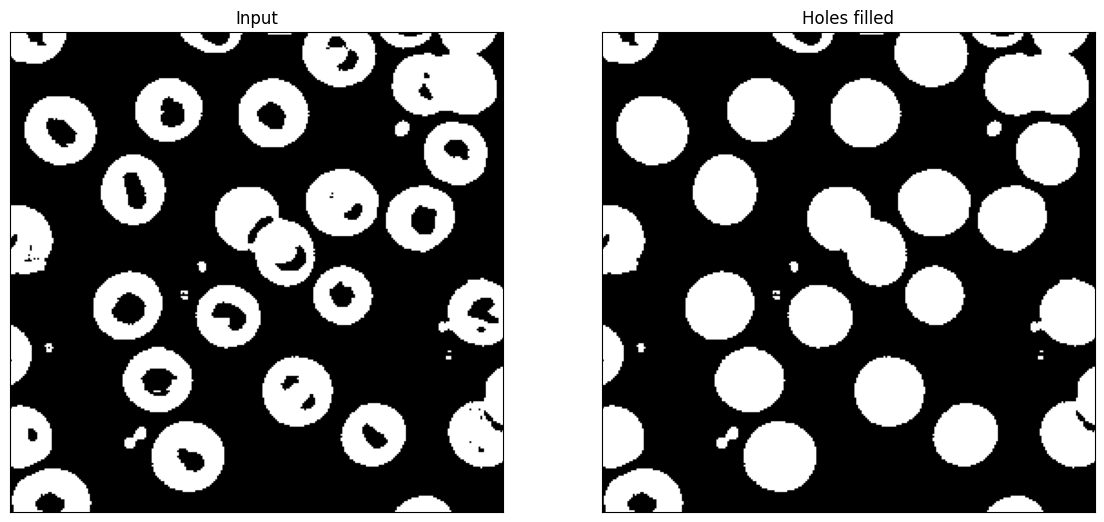

In [ ]:
def hole_fill(img):
    max_row, max_col = img.shape
    img_seed = np.zeros(img.shape)
    img_seed[0,:] = 255-img[0,:]
    img_seed[max_row-1,:] = 255-img[max_row-1,:]
    img_seed[:,0] = 255-img[:,0]
    img_seed[:, max_col-1] = 255-img[:, max_col-1]
    img_comp = 255-img
    img_bg = morpho_reconstruct(img_comp, img_seed)
    return 255-img_bg


filename = 'holes.png'
img = cv2.imread(image_path + filename, 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)

img_bw_noho = hole_fill(img)

plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(img,cmap = 'gray')
plt.title('Input'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img_bw_noho,cmap = 'gray')
plt.title('Holes filled'), plt.xticks([]), plt.yticks([])
plt.show()

# procedura

## Comments
Questa pipeline di operazioni serve per andare a riempire degli eventuali buchi che possiamo avere in un'immagine. In questo caso il risultato che abbiamo nell'immagine di uscita comporta la rimozione e "copertura" di buchi in modo da ottenere un'immagine più uniforme.

## Morphological TopHat for better Thresholding

Image size  (256, 256)  Depth:  uint8


Text(0.5, 1.0, 'Otsu on TopHat')

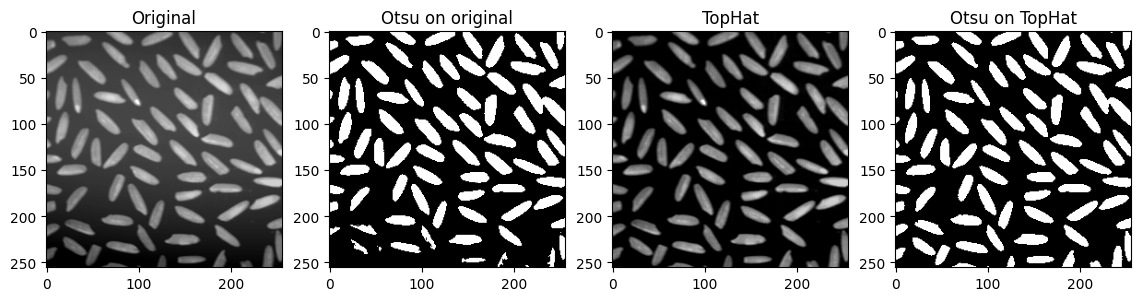

In [ ]:
img = cv2.imread(image_path + 'rice.tif', 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)

# Apply Otsu on original image
trsh, img_bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Define the structuring element
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))

img_topHat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, se)
# Apply Otsu on TopHat image
trsh, img_bw_topHat = cv2.threshold(img_topHat,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


plt.figure(figsize=(14,8))
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(img_bw , cmap='gray')
plt.title('Otsu on original')
plt.subplot(1,4,3)
plt.imshow(img_topHat, cmap='gray')
plt.title('TopHat')
plt.subplot(1,4,4)
plt.imshow(img_bw_topHat, cmap='gray')
plt.title('Otsu on TopHat')


## Comments
L'immagine originale, sottoposta a Otsu, presenta delle criticità ovvero chicchi non ben evidenziati. Se prima dell'applicazione di Otsu si fa Top-hat, la quale riduce dinamica del background, il risultato migliora. Un buon risultato è quello che otteniamo lasciando invariato il valore del raggio dell'elemento strutturante (19).
Andando a modificare il raggio e scegliendone uno più piccolo, per esempio 5, possiamo notare come la "TopHat" e "Otsu con TopHat" diano dei pessimi risultati contro l'applicazione di Otsu pura, che risulta migliore. Lo stesso risultato lo otteniamo su alziamo il raggio a 10. Se alziamo il raggio rispetto a quello di partenza e lo portiamo a 25 possiamo notare che "Otsu con TopHat" dà questa volta dei risultati migliori. Il criterio di un buon risultato sta nella scelta di un raggio adeguato.

## Use MM to to better contrast cell regions from the background

Image size  (260, 348)  Depth:  uint8


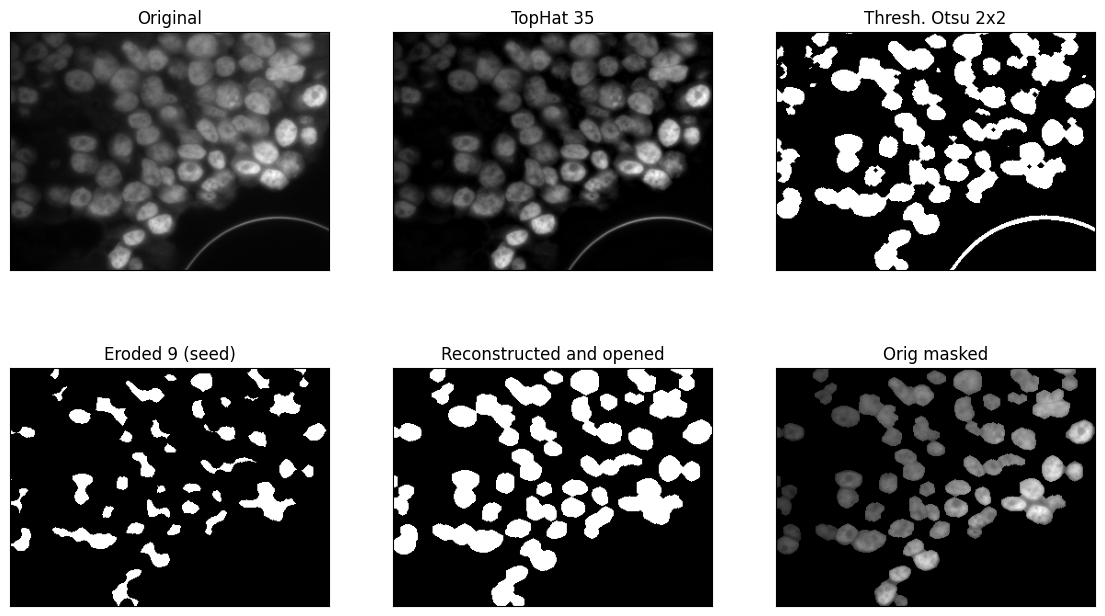

In [ ]:
filename = 'cells.bmp'
img = cv2.imread(image_path + filename, 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)

radius = 50
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_th = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, se)
img_bh = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, se)
#img_th = img + img_th
img_bw = cv2.adaptiveThreshold(img_th, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,71,-10)
radius = 3
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se, iterations=2)
img_bw_noho = hole_fill(img_bw)
radius = 9
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_seed = cv2.erode(img_bw_noho, se, iterations = 1)
img_reco = morpho_reconstruct(img_bw_noho, img_seed)
img_reco = cv2.morphologyEx(img_reco, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations=2)
img_out = img * (img_reco / 255)

plt.figure(figsize=(14,8))
plt.subplot(2,3,1), plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2), plt.imshow(img_th,cmap = 'gray')
plt.title('TopHat 35'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3), plt.imshow(img_bw,cmap = 'gray')
plt.title('Thresh. Otsu 2x2'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,4), plt.imshow(img_seed,cmap = 'gray')
plt.title('Eroded %d (seed)'%(radius)), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5), plt.imshow(img_reco,cmap = 'gray')
plt.title('Reconstructed and opened'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,6), plt.imshow(img_out,cmap = 'gray')
plt.title('Orig masked'), plt.xticks([]), plt.yticks([])
plt.show()


## Comments
Queste sono una serie di operazione per evidenziare bene le cellule, in cui l'obiettivo sta nel trasformare l'immagine di partenza in una immagine dove le cellule sono più marcate e vengono rimossi gli artefatti che non sono cellule. Tutto questo segue una pipeline di diverse operazioni: TopHat per attenuare dinamica del background, sogliatura con Otsu, erosione, ricostruzione e apertura per regolarizzare il tutto, e infine l'ottenimento della maschera. Dei buoni risultati si possono ottenere con il raggio di partenza, ovvero 35, andando però a diminuirlo a 15, possiamo notare come nella maschera finale vengano perse tante informazioni relative alle cellule che volevamo mantenere, portando quindi a un cattivo risultato. Aumentando il raggio a 50 riusciamo invece ad ottenere tutte le cellule senza perdità di informazione.


## Use MM to compute the histogram of image regions

Image size  (265, 272)  Depth:  uint8


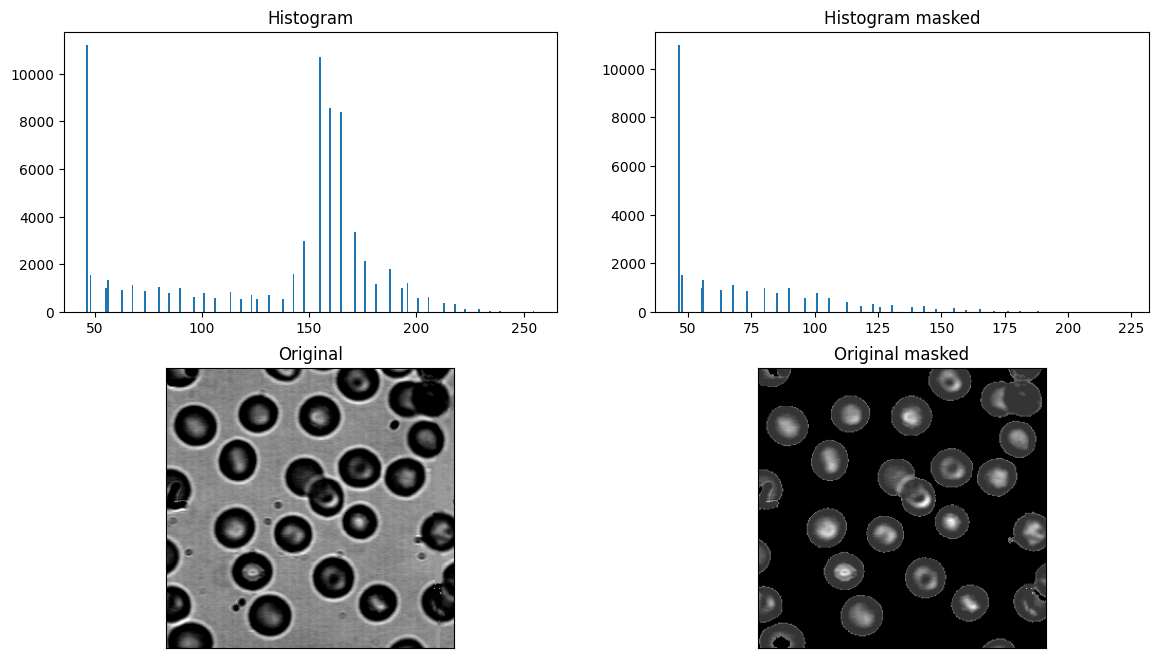

In [ ]:
filename = 'blood1.tif'
img = cv2.imread(image_path + filename, 0)
print('Image size ', img.shape, ' Depth: ', img.dtype)


# Threshold
trsh, img_bw = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Invert
img_bw_neg = 255 - img_bw
# Fill holes
img_bw_neg_noho = hole_fill(img_bw_neg)
# Erode and reconstruct to remove small isolated regions
radius = 12
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_seed = cv2.erode(img_bw_neg_noho, se, iterations = 1)
img_reco = morpho_reconstruct(img_bw_neg_noho, img_seed)
# Use the reconstruction as a mask to identify pixels of interest
vals_of_interest = img[ img_reco == 255 ] # immagine, lvl dell'immagine nei punti della maschera è = 255, estraggo solo i lvl di grigio è uguale a un certo valore
# questo mi dà un vettore con i lvl di grigio corrispondenti ai 255 della maschera, restituisce hist numero 2
orig_masked = img * (img_reco / 255)

plt.figure(figsize=(14,8))
plt.subplot(2,2,1), plt.hist(img.reshape(-1), 256)
#plt.axvline(x=trsh, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram')#, plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.hist(vals_of_interest.reshape(-1), 256)
plt.title('Histogram masked')#, plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3), plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4), plt.imshow(orig_masked,cmap = 'gray')
plt.title('Original masked'), plt.xticks([]), plt.yticks([])
plt.show()



## Comments
Ho delle cellule su uno sfondo, dobbiamo estrarre istogramme delle cellule stesse escludendo il background. Il primo istogramma rappresenta tutta l'immagine, mentre il secondo è qiello relativo alle sole cellule.
Viene definita una serie di operazioni che estraggono una maschera per i pixel che sono delle cellule. Viene creata una maschera binaria, in cui il background è a 0 e 1 è per il pixel delle cellule, faccio una sogliatura e inverto il risultato, tolgo i buchi, erodo per ricostruire con il fine di togliere gli spot scuri, in quanto sono troppo piccoli per essere cellule. Come risultato ho la maschera delle cellule. Con il valore di partenza pari a 9, possiamo vedere come si piò ottenere una mschera senza spot neri, lasciando quindi in evidenza le cellule. Un raggio troppo piccolo invece, 3, porterà invece alla comparsa dei vari spot che volevamo invece eliminare, rendeno questa maschera inutile per i nostri scopi. Un raggio superiore, 12, invece darà dei buoni risultati simili a quelli del valore di partenza.

## Use MM operators to process CT chest images and extract a mask of the lungs

Image size  (512, 512)  Depth:  uint16


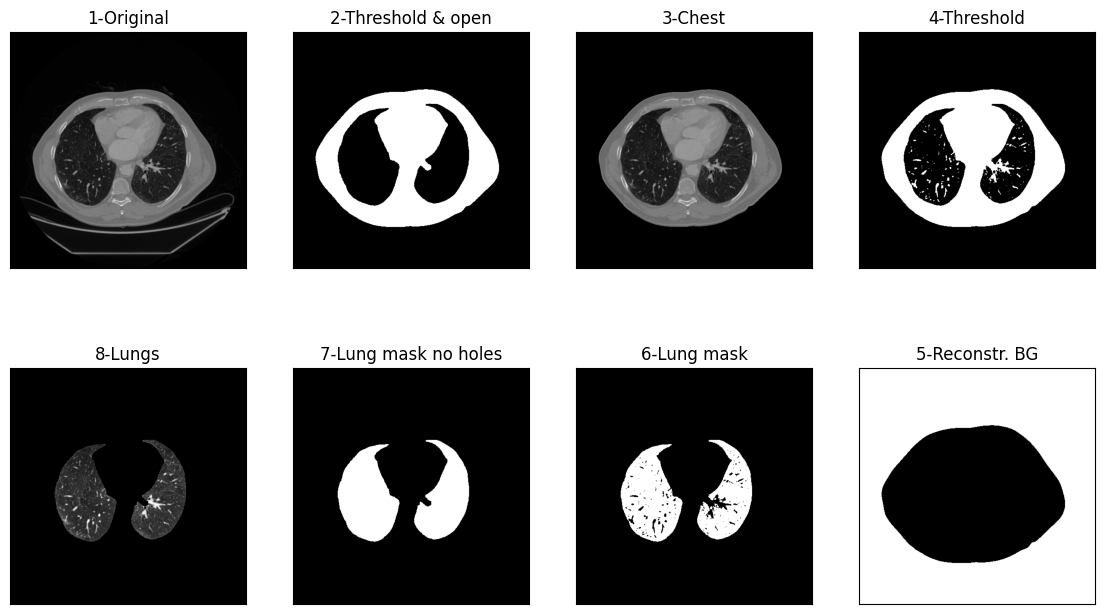

In [ ]:
#filename = 'CT_lung_slices/slice-80.png'
#filename = 'CT_lung_slices/slice-100.png'
filename = 'CT_lung_slices/slice-120.png'
#filename = 'CT_lung_slices/slice-210.png'

img = cv2.imread(image_path + filename, -1) # Images are stored with one 16bit graylevel channel
print('Image size ', img.shape, ' Depth: ', img.dtype)

# Map the 16-bit image to full range 8-bit
img_norm = (img.astype('float') / np.max(img) * 255.0).astype('uint8')
# Threshold
trsh, img_bw = cv2.threshold(img_norm,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Open to remove lines and then fill holes
radius = 11
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, se, iterations=1)
img_chest_mask = hole_fill(img_bw)
img_chest = (img_norm * (img_chest_mask / 255)).astype('uint8')


trsh, img_chest_bw = cv2.threshold(img_chest,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#Fill the BG
img_chest_bw_neg = 255 - img_chest_bw
img_seed_bg = np.zeros(img_chest_bw_neg.shape)
img_seed_bg[1,1]=255
img_reco_bg = morpho_reconstruct(img_chest_bw_neg, img_seed_bg)
img_lungs_mask = 255 - (img_reco_bg+img_chest_bw)

# Close and fill lung holes
radius = 5
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius,radius))
img_lungs_mask_noho = cv2.morphologyEx(img_lungs_mask, cv2.MORPH_CLOSE,
                                       se, iterations=3)
img_lungs_mask_noho = hole_fill(img_lungs_mask_noho)

img_lungs = (img_chest * (img_lungs_mask_noho / 255))

plt.figure(figsize=(14,8))
plt.subplot(2, 4,1), plt.imshow(img_norm, cmap = 'gray')
plt.title('1-Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 4, 2), plt.imshow(img_bw, cmap = 'gray')
plt.title('2-Threshold & open'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 4, 3), plt.imshow(img_chest, cmap = 'gray')
plt.title('3-Chest'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 4, 4), plt.imshow(img_chest_bw, cmap = 'gray')
plt.title('4-Threshold'), plt.xticks([]), plt.yticks([])
plt.subplot(2,4,8), plt.imshow(img_reco_bg, cmap = 'gray')
plt.title('5-Reconstr. BG'), plt.xticks([]), plt.yticks([])
plt.subplot(2,4,7), plt.imshow(img_lungs_mask, cmap = 'gray')
plt.title('6-Lung mask'), plt.xticks([]), plt.yticks([])
plt.subplot(2,4,6), plt.imshow(img_lungs_mask_noho, cmap = 'gray')
plt.title('7-Lung mask no holes'), plt.xticks([]), plt.yticks([])
plt.subplot(2,4,5), plt.imshow(img_lungs, cmap = 'gray')
plt.title('8-Lungs'), plt.xticks([]), plt.yticks([])
plt.show()



## Comments
Abbiamo una slice di una tomografia computerizzata del busto, vogliamo rimuovere gli artefatti e avere una mascehera che evidenzi la regione dei polmoni. Per fare ciò, si fa una pipeline di operazioni: si fa sogliatura + apertura, chest da qui si risoglia, ricostruisco parte esterna + complemento, maschera polmoni con spot, che voglio preservare, tolgo i buchi, apertura che regolirriza il contorno, lo uso come maschera per prendere quella di partenza. La scelta della dimensione degli operatori è fondamentali per buoni risultati.

Funziona anche su immagini dove il polmone è diverso, cambio immagini, cambia la quota sezione del busto, nonostante questo, questa pipeline ha successo.